In [112]:
import numpy as np
from numpy import linalg as LA
from scipy.linalg import null_space
from ncon import ncon


N = 4
mps = np.random.random(2**N) #+  np.random.random(2**N) * 1j
mps_norm = mps / LA.norm(mps)
psi_norm = mps_norm / LA.norm(mps_norm)
psi = psi_norm.reshape(2,2,2,2)
print(LA.norm(psi_norm))
print(psi_norm)

mps_sites = [0 for _ in range(N)]
mps_sites_iso = [0 for _ in range(N)]

Atemp, Stemp, Vhtemp = LA.svd(psi.reshape(2,2**(N-1)), full_matrices=False)
mps_sites[0] = Atemp.reshape(1,2,2)  #shape della matrice A_1 ---> A_8 paper è 2,2 - mapping 1 a 1
mps_sites[1] = (np.diag(Stemp)@Vhtemp)/LA.norm(Stemp)

for i in range(1,N-1):
    Atemp, Stemp, Vhtemp = LA.svd(mps_sites[i].reshape(2**2,2**(N-i-1)), full_matrices=False)
    mps_sites[i] = Atemp[:,:2].reshape(2,2,2)
    mps_sites[i+1] = ((np.diag(Stemp[:2])@Vhtemp[:2,:]).reshape(2,-1))/LA.norm(Stemp)

mps_sites[-1] = ((np.diag(Stemp[:2])@Vhtemp[:2,:]).reshape(2,2,1))/LA.norm(Stemp)


print("Checking Isometries:")
for i,site in enumerate(mps_sites):
    print("\n------------\n\nA{} tensor of the MPS".format(i+1))
    print("+ Isometry computed with NCON")
    print(np.round((ncon([site,site],[[1,2,-1],[1,2,-2]]))))
    print("+ Isometry computed with NCON on reshaped tensors")
    print(np.round(ncon([site.reshape(site.shape[0]*site.shape[1], site.shape[2]),
                         site.reshape(site.shape[0]*site.shape[1], site.shape[2])],[[1,-1],[1,-2]])))
    mps_sites_iso[i] = site.reshape(site.shape[0]*site.shape[1], site.shape[2])
    print("+ Isometry check with @ op")
    print("++ Identity A^dagA")
    print(np.round(mps_sites_iso[i].T@mps_sites_iso[i]))
    print("++ Projector AA^dag")
    print(mps_sites_iso[i]@mps_sites_iso[i].T)

print("\n------------\n\n")
print("MPS single tensors shapes = {}".format([i.shape for i in mps_sites]))
print("Single site inds [virt, phys, virt] -> [j, l, k]")
print("MPS matrix form shapes (j,l,k) -> (j*l,k) = {}".format([i.shape for i in mps_sites_iso]))




1.0
[0.06663846 0.21940998 0.06864712 0.03837117 0.30239795 0.08933746
 0.46709169 0.03587763 0.32371891 0.01586199 0.15428838 0.09165208
 0.41603016 0.33061424 0.45002883 0.01352353]
Checking Isometries:

------------

A1 tensor of the MPS
+ Isometry computed with NCON
[[ 1. -0.]
 [-0.  1.]]
+ Isometry computed with NCON on reshaped tensors
[[ 1. -0.]
 [-0.  1.]]
+ Isometry check with @ op
++ Identity A^dagA
[[ 1. -0.]
 [-0.  1.]]
++ Projector AA^dag
[[ 1.00000000e+00 -2.86878092e-16]
 [-2.86878092e-16  1.00000000e+00]]

------------

A2 tensor of the MPS
+ Isometry computed with NCON
[[1. 0.]
 [0. 1.]]
+ Isometry computed with NCON on reshaped tensors
[[1. 0.]
 [0. 1.]]
+ Isometry check with @ op
++ Identity A^dagA
[[1. 0.]
 [0. 1.]]
++ Projector AA^dag
[[ 0.14238672  0.34816856 -0.02645448  0.01384037]
 [ 0.34816856  0.85858439  0.00622175 -0.01253704]
 [-0.02645448  0.00622175  0.70022087 -0.45735441]
 [ 0.01384037 -0.01253704 -0.45735441  0.29880802]]

------------

A3 tensor of t

![Screenshot from 2023-11-10 15-00-15.png](<attachment:Screenshot from 2023-11-10 15-00-15.png>)
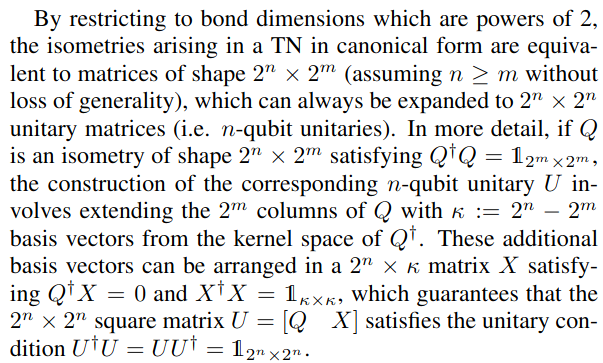

SNIPPET DI CODICE PER L'ESTENSIONE DELLE ISOMETRIE DI DIMENSIONE 2^n x 2^m A MATRICI UNITARIE 2^n x 2^n


In [113]:

print("Creating null_spaces and G matrix [A, X] where X is such that A^dagX = 0 and X^dagX = I\n\n")

G_swap = [0 for _ in range(N)]
kernel = [0 for _ in range(N)]
G = [0 for _ in range(N)]
for i,Q in enumerate(mps_sites_iso):
    print("A{} tensor\n".format(i+1))

    print("+ Tensor:\n{}".format(Q))

    #check isometry
    assert (np.round(Q.T@Q) - np.eye(Q.shape[1]) == np.zeros((Q.shape[1],Q.shape[1]))).all()

    X = null_space(Q.conjugate().T)
    kernel[i] = X
    print("k = null space vectors: \n{}\n-shape: {}".format(X, X.shape))
    print("Add to Q of shape {}, the matrix X which has shape {}".format(Q.shape, X.shape))

    #check extension shape
    assert(Q.shape[0] == X.shape[0] and Q.shape[1] + X.shape[1] == Q.shape[0])

    #check orthogonality
    assert (np.round(Q.conjugate().T@X) == np.zeros((X.shape[1]))).all()

    #check unitarity
    assert (np.round(X.conjugate().T @ X) == np.eye(X.shape[1])).all()

    #extend the isometry: U = [Q X]
    G[i] = np.block([Q, X])
    print("\nG = [Q X] matrix with shape {}:\n{}".format(G[i].shape, G[i]))
    G_swap[i] = np.block([X, Q])
    print("\nG_swap = [X Q] matrix with shape {}:\n{}".format(G_swap[i].shape, G_swap[i]))

    #check unitarity of G matrix = [Q X] 
    assert (np.round(G[i].conjugate().T@G[i]) == np.eye(Q.shape[0])).all()
    assert (np.round(G[i]@G[i].conjugate().T) == np.eye(Q.shape[0])).all()

    #check unitarity of G_swap matrix = [X Q]
    assert (np.round(G_swap[i].conjugate().T@G_swap[i]) == np.eye(Q.shape[0])).all()
    assert (np.round(G_swap[i]@G_swap[i].conjugate().T) == np.eye(Q.shape[0])).all()

    print("\n-----------\n")



Creating null_spaces and G matrix [A, X] where X is such that A^dagX = 0 and X^dagX = I


A1 tensor

+ Tensor:
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]
k = null space vectors: 
[]
-shape: (2, 0)
Add to Q of shape (2, 2), the matrix X which has shape (2, 0)

G = [Q X] matrix with shape (2, 2):
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]

G_swap = [X Q] matrix with shape (2, 2):
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]

-----------

A2 tensor

+ Tensor:
[[-0.37730667  0.00513803]
 [-0.92376024 -0.07246663]
 [ 0.05874698 -0.8347273 ]
 [-0.02924881  0.54585028]]
k = null space vectors: 
[[ 0.77922659 -0.50041903]
 [-0.3118805   0.21010989]
 [ 0.31949527  0.44463682]
 [ 0.43984003  0.71255367]]
-shape: (4, 2)
Add to Q of shape (4, 2), the matrix X which has shape (4, 2)

G = [Q X] matrix with shape (4, 4):
[[-0.37730667  0.00513803  0.77922659 -0.50041903]
 [-0.92376024 -0.07246663 -0.3118805   0.21010989]
 [ 0.05874698 -0.8347273   0.31949527  0.44463

CHECKING INDEX PAIRING BETWEEN EXTENDED ISOMETRIES G AND ORIGINAL ISOMETRIES

In [114]:
for i,t in enumerate(mps_sites):
    print("A{} tens\n\n+Shape {}\n{}\n".format(i,t.shape,t))
    print("A{} isometry matrix\n+Shape {}\n{}\n".format(i,mps_sites_iso[i].shape, mps_sites_iso[i]))
    print("G{} unitary\n + Shape {}\n{}\n".format(i,G[i].shape, G[i]))
    print("\n---------\n")

#check degli indici della matrice unitaria G2 corrispondente al tensore A2

a = mps_sites[1]
g = G[1]

print("Tens A1 as (2,2,2): \n{}\n".format(a))
print("Unitary G1 as (2,2,2,2): \n{}\n\n".format(g.reshape(2,2,2,2)[:,:,:,:]))

# A matrix 4x2 has been added to A1 to obtain G1, so when one index is 0, G[1][0,:,:,:] = A[1][:,:,:]
# otherwise we get the kernel vector when G[1][1,:,:,:] = kernel[1][:,:,:]
# we need to find this index 
print("Unitary G[1][0,:,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[0,:,:,:]))
print(str((g.reshape(2,2,2,2)[0,:,:,:]  == a[:,:,:]).all())+"\n")
print("Unitary G[1][:,0,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,0,:,:]))
print(str((g.reshape(2,2,2,2)[:,0,:,:]  == a[:,:,:]).all())+"\n")

print("Unitary G[1][:,:,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,0,:]))
print(str((g.reshape(2,2,2,2)[:,:,0,:]  == a[:,:,:]).all())+"\n")

print("Unitary G[1][:,:,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,:,0]))
print(str((g.reshape(2,2,2,2)[:,:,:,0]  == a[:,:,:]).all())+"\n")
#so for the central matrix, the 3rd index, correspond to the index that has to be put to 0 to obtain A1

a = mps_sites[2]
g = G[2]

print("Tens A1 as (2,2,2): \n{}\n".format(a))
print("Unitary G1 as (2,2,2,2): \n{}\n\n".format(g.reshape(2,2,2,2)[:,:,:,:]))

# A matrix 4x3 has been added to A2 to obtain G2, so when two indices are 0, G[2][0,0,:,:] = A[2][:,:]
# otherwise we get the kernel vector when G[2][1,0,:,:], G[2][0,1,:,:], G[2][1,1,:,:]
# we need to find this index 
print("Unitary G[2][0,0,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[0,0,:,:]))
print(str((g.reshape(2,2,2,2)[0,0,:,:]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][:,0,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,0,0,:]))
print(str((g.reshape(2,2,2,2)[:,0,0,:]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][:,:,0,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,0,0]))
print(str((g.reshape(2,2,2,2)[:,:,0,0]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][:,0,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,0,:,0]))
print(str((g.reshape(2,2,2,2)[:,0,:,0]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][0,:,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[0,:,:,0]))
print(str((g.reshape(2,2,2,2)[0,:,:,0]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][0,:,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[0,:,0,:]))
print(str((g.reshape(2,2,2,2)[0,:,0,:]  == a[:,:,0]).all())+"\n")
#so for the central matrix, the 3rd and 4th indices, correspond to the indices that have to be put to 0 to obtain A2



A0 tens

+Shape (1, 2, 2)
[[[-0.59621478 -0.80282497]
  [-0.80282497  0.59621478]]]

A0 isometry matrix
+Shape (2, 2)
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]

G0 unitary
 + Shape (2, 2)
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]


---------

A1 tens

+Shape (2, 2, 2)
[[[-0.37730667  0.00513803]
  [-0.92376024 -0.07246663]]

 [[ 0.05874698 -0.8347273 ]
  [-0.02924881  0.54585028]]]

A1 isometry matrix
+Shape (4, 2)
[[-0.37730667  0.00513803]
 [-0.92376024 -0.07246663]
 [ 0.05874698 -0.8347273 ]
 [-0.02924881  0.54585028]]

G1 unitary
 + Shape (4, 4)
[[-0.37730667  0.00513803  0.77922659 -0.50041903]
 [-0.92376024 -0.07246663 -0.3118805   0.21010989]
 [ 0.05874698 -0.8347273   0.31949527  0.44463682]
 [-0.02924881  0.54585028  0.43984003  0.71255367]]


---------

A2 tens

+Shape (2, 2, 2)
[[[-0.71848654  0.43178342]
  [-0.69343042 -0.44758948]]

 [[ 0.00304137  0.78170019]
  [ 0.05405639 -0.04659984]]]

A2 isometry matrix
+Shape (4, 2)
[[-0.71848654  0.4317834

In [115]:
for i,t in enumerate(mps_sites):
    print("A{} tens\n\n+Shape {}\n{}\n".format(i,t.shape,t))
    print("A{} isometry matrix\n+Shape {}\n{}\n".format(i,mps_sites_iso[i].shape, mps_sites_iso[i]))
    print("G_swap{} unitary\n + Shape {}\n{}\n".format(i,G_swap[i].shape, G_swap[i]))
    print("\n---------\n")

#check degli indici della matrice unitaria G2 corrispondente al tensore A2

a = mps_sites[1]
g = G_swap[1]

print("Tens A1 as (2,2,2): \n{}\n".format(a))
print("Unitary G1 as (2,2,2,2): \n{}\n\n".format(g.reshape(2,2,2,2)[:,:,:,:]))

# A matrix 4x2 has been added to A1 to obtain G1, so when one index is 0, G[1][0,:,:,:] = A[1][:,:,:]
# otherwise we get the kernel vector when G[1][1,:,:,:] = kernel[1][:,:,:]
# we need to find this index 
print("Unitary G[1][0,:,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[0,:,:,:]))
print(str((g.reshape(2,2,2,2)[0,:,:,:]  == a[:,:,:]).all())+"\n")
print("Unitary G[1][:,0,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,0,:,:]))
print(str((g.reshape(2,2,2,2)[:,0,:,:]  == a[:,:,:]).all())+"\n")

print("Unitary G[1][:,:,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,0,:]))
print(str((g.reshape(2,2,2,2)[:,:,0,:]  == a[:,:,:]).all())+"\n")

print("Unitary G[1][:,:,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,:,0]))
print(str((g.reshape(2,2,2,2)[:,:,:,0]  == a[:,:,:]).all())+"\n")
#so for the central matrix, the 3rd index, correspond to the index that has to be put to 0 to obtain A1

print("\n--------\n")
print("Unitary G[1][0,:,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[1,:,:,:]))
print(str((g.reshape(2,2,2,2)[1,:,:,:]  == kernel[1].reshape(2,2,2)[:,:,:]).all())+"\n")

print("Unitary G[1][:,0,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,1,:,:]))
print(str((g.reshape(2,2,2,2)[:,1,:,:]  == kernel[1].reshape(2,2,2)[:,:,:]).all())+"\n")

print("Unitary G[1][:,:,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,1,:]))
print(str((g.reshape(2,2,2,2)[:,:,1,:]  == kernel[1].reshape(2,2,2)[:,:,:]).all())+"\n")

print("Unitary G[1][:,:,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,:,1]))
print(str((g.reshape(2,2,2,2)[:,:,:,1]  == kernel[1].reshape(2,2,2)[:,:,:]).all())+"\n")
#check on the kernel[1] to have the right value when we give 1 as 3rd index to G[1], G[1][:,:,1,:] = kernel[1][:,:,:]


a = mps_sites[2]
g = G_swap[2]

print("Tens A1 as (2,2,2): \n{}\n".format(a))
print("Unitary G1 as (2,2,2,2): \n{}\n\n".format(g.reshape(2,2,2,2)[:,:,:,:]))

# A matrix 4x3 has been added to A2 to obtain G2, so when two indices are 0, G[2][0,0,:,:] = A[2][:,:]
# otherwise we get the kernel vector when G[2][1,0,:,:], G[2][0,1,:,:], G[2][1,1,:,:]
# we need to find this index 
print("Unitary G[2][0,0,:,:]: \n\n{}".format(g.reshape(2,2,2,2)[0,0,:,:]))
print(str((g.reshape(2,2,2,2)[0,0,:,:]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][:,0,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[:,0,0,:]))
print(str((g.reshape(2,2,2,2)[:,0,0,:]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][:,:,0,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,:,0,0]))
print(str((g.reshape(2,2,2,2)[:,:,0,0]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][:,0,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[:,0,:,0]))
print(str((g.reshape(2,2,2,2)[:,0,:,0]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][0,:,:,0]: \n\n{}".format(g.reshape(2,2,2,2)[0,:,:,0]))
print(str((g.reshape(2,2,2,2)[0,:,:,0]  == a[:,:,0]).all())+"\n")

print("Unitary G[2][0,:,0,:]: \n\n{}".format(g.reshape(2,2,2,2)[0,:,0,:]))
print(str((g.reshape(2,2,2,2)[0,:,0,:]  == a[:,:,0]).all())+"\n")
#so for the central matrix, the 3rd and 4th indices, correspond to the indices that have to be put to 0 to obtain A2



A0 tens

+Shape (1, 2, 2)
[[[-0.59621478 -0.80282497]
  [-0.80282497  0.59621478]]]

A0 isometry matrix
+Shape (2, 2)
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]

G_swap0 unitary
 + Shape (2, 2)
[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]


---------

A1 tens

+Shape (2, 2, 2)
[[[-0.37730667  0.00513803]
  [-0.92376024 -0.07246663]]

 [[ 0.05874698 -0.8347273 ]
  [-0.02924881  0.54585028]]]

A1 isometry matrix
+Shape (4, 2)
[[-0.37730667  0.00513803]
 [-0.92376024 -0.07246663]
 [ 0.05874698 -0.8347273 ]
 [-0.02924881  0.54585028]]

G_swap1 unitary
 + Shape (4, 4)
[[ 0.77922659 -0.50041903 -0.37730667  0.00513803]
 [-0.3118805   0.21010989 -0.92376024 -0.07246663]
 [ 0.31949527  0.44463682  0.05874698 -0.8347273 ]
 [ 0.43984003  0.71255367 -0.02924881  0.54585028]]


---------

A2 tens

+Shape (2, 2, 2)
[[[-0.71848654  0.43178342]
  [-0.69343042 -0.44758948]]

 [[ 0.00304137  0.78170019]
  [ 0.05405639 -0.04659984]]]

A2 isometry matrix
+Shape (4, 2)
[[-0.71848654 

CONVERT G OF SHAPE (2,2)(4,4)(4,4) INTO GR4 WITH SHAPE (2,2)(2,2,2,2)(2,2,2,2)

In [116]:

gr4 = [i.reshape(2,2) if i.size ==4 else i.reshape(2,2,2,2) for i in G]

for i in gr4:
    print(i)
    print(i.shape)

assert (gr4[1][:,:,0,:] == mps_sites[1][:,:,:]).all()
assert (gr4[2][:,:,0,:] == mps_sites[2][:,:,:]).all() #last index is dimension 1 and has only entry 1 (2,2,1)
assert (gr4[3][:,:,0,0] == mps_sites[3][:,:,0]).all()


[[-0.59621478 -0.80282497]
 [-0.80282497  0.59621478]]
(2, 2)
[[[[-0.37730667  0.00513803]
   [ 0.77922659 -0.50041903]]

  [[-0.92376024 -0.07246663]
   [-0.3118805   0.21010989]]]


 [[[ 0.05874698 -0.8347273 ]
   [ 0.31949527  0.44463682]]

  [[-0.02924881  0.54585028]
   [ 0.43984003  0.71255367]]]]
(2, 2, 2, 2)
[[[[-0.71848654  0.43178342]
   [-0.53983026  0.07696401]]

  [[-0.69343042 -0.44758948]
   [ 0.56463623 -0.00196182]]]


 [[[ 0.00304137  0.78170019]
   [ 0.62344697  0.01579356]]

  [[ 0.05405639 -0.04659984]
   [ 0.03291057  0.99690684]]]]
(2, 2, 2, 2)
[[[[-0.90225539 -0.29372798]
   [-0.09772378  0.30018186]]

  [[-0.29372798  0.95464535]
   [-0.01508957  0.04635119]]]


 [[[-0.09772378 -0.01508957]
   [ 0.99497968  0.01542112]]

  [[ 0.30018186  0.04635119]
   [ 0.01542112  0.95263036]]]]
(2, 2, 2, 2)


In [117]:
mps000 = np.zeros((2,2,2,2))

mps000[0,0,0,0] = 1.
print(mps000)
assert np.round(LA.norm(mps000),8) == 1.

[[[[1. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]]]]


In [118]:
mpsTrunc = ncon([mps_sites[0], mps_sites[1], mps_sites[2], mps_sites[3]],[[-1,-2,1],[1,-3,2],[2,-4,3],[3,-5,-6]])[0,:,:,:,:,0] #remove the first and last index of size 1 (1,2,2,2,1)-> (2,2,2)
assert np.round(LA.norm(mpsTrunc),8) == 1.

UNITARITY COMPOSITION CHECK


In [119]:
#gr4[0]@gr[0]^dag == gr4[0]^dag@gr4[0] == I2

print("Gr[0]")
print("UU^dag == I2")
UUd = ncon([gr4[0],gr4[0]],[[-1,1],[-2,1]])
print(UUd)
assert (np.round(UUd) == np.eye(UUd.shape[0])).all()
print("U^dagU == I2")
UdU = ncon([gr4[0],gr4[0]],[[1,-1],[1,-2]])
print(UdU)
assert (np.round(UdU) == np.eye(UdU.shape[0])).all()

print("\n\n----------\n\n")
print("Gr[1]\n")
print("UU^dag == I4")
#gr4[1]@gr[1]^dag == gr4[1]^dag@gr4[1] == I4
UUd = ncon([gr4[1],gr4[1]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4[1],gr4[1]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()


print("\n\n----------\n\n")
print("Gr[2]\n")
print("UU^dag == I4")
#gr4[2]@gr[2]^dag == gr4[2]^dag@gr4[2] == I4
UUd = ncon([gr4[2],gr4[2]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4[2],gr4[2]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()



print("\n\n----------\n\n")
print("Gr[3]\n")
print("UU^dag == I4")
#gr4[3]@gr[3]^dag == gr4[3]^dag@gr4[3] == I4
UUd = ncon([gr4[3],gr4[3]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
#assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4[3],gr4[3]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
#assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()

Gr[0]
UU^dag == I2
[[ 1.00000000e+00 -2.86878092e-16]
 [-2.86878092e-16  1.00000000e+00]]
U^dagU == I2
[[ 1.00000000e+00 -2.86878092e-16]
 [-2.86878092e-16  1.00000000e+00]]


----------


Gr[1]

UU^dag == I4
[[[[ 1.  0.]
   [-0.  0.]]

  [[ 0.  1.]
   [ 0.  0.]]]


 [[[-0.  0.]
   [ 1. -0.]]

  [[ 0.  0.]
   [-0.  1.]]]]
[[ 1.  0. -0.  0.]
 [ 0.  1.  0.  0.]
 [-0.  0.  1. -0.]
 [ 0.  0. -0.  1.]]
U^dagU == I4
[[[[ 1.  0.]
   [ 0.  0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[ 0.  0.]
   [ 1. -0.]]

  [[ 0. -0.]
   [-0.  1.]]]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0. -0.]
 [ 0.  0.  1. -0.]
 [ 0. -0. -0.  1.]]


----------


Gr[2]

UU^dag == I4
[[[[ 1.  0.]
   [ 0.  0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[ 0.  0.]
   [ 1. -0.]]

  [[ 0. -0.]
   [-0.  1.]]]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0. -0.]
 [ 0.  0.  1. -0.]
 [ 0. -0. -0.  1.]]
U^dagU == I4
[[[[ 1. -0.]
   [-0.  0.]]

  [[-0.  1.]
   [ 0. -0.]]]


 [[[-0.  0.]
   [ 1.  0.]]

  [[ 0. -0.]
   [ 0.  1.]]]]
[[ 1. -0. -0.  0.]
 [-0.  1.  0. -0.]
 

In [120]:
#check first composition Gr4[1]Gr4[0]
MPO = ncon([gr4[3], gr4[2],gr4[1],gr4[0]],[[1,-5,-2,-1],[2,-6,-3,1],[3,-7,-4, 2],[3,-8]])   #FUNZIONA  
MPSMPO = ncon([mps000,MPO],[[1,2,3,4],[4,3,2,1,-4,-3,-2,-1]])
print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO applied: \n{}".format(MPSMPO))
print(ncon([mpsTrunc, MPSMPO],[[1,2,3,4],[1,2,3,4]]))

MPS OG: 
[[[[ 0.05496433  0.21650057]
   [ 0.08951533 -0.00759825]]

  [[ 0.3792858   0.10327844]
   [ 0.40185929  0.05160504]]]


 [[[ 0.24452105 -0.00218129]
   [ 0.24840122  0.03841332]]

  [[ 0.40854027  0.33636898]
   [ 0.4677961   0.03874394]]]]
MPO 000 with MPO applied: 
[[[[ 0.05496433  0.21650057]
   [ 0.08951533 -0.00759825]]

  [[ 0.3792858   0.10327844]
   [ 0.40185929  0.05160504]]]


 [[[ 0.24452105 -0.00218129]
   [ 0.24840122  0.03841332]]

  [[ 0.40854027  0.33636898]
   [ 0.4677961   0.03874394]]]]
0.9999999999999993


In [26]:
#REORDERED MPO 

MPO2 = ncon([gr4[3].T,gr4[2].T,gr4[1].T,gr4[0]],[[-1,-2,1,-5],[1,-3,-6,2],[2,-4,-7, 3],[3,-8]])
MPSMPO2 = ncon([mps000, MPO2],[[4,3,2,1],[1,2,3,4,-1,-2,-3,-4]])

print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO2 applied: \n{}".format(MPSMPO2))
print(ncon([mpsTrunc, MPSMPO2.T],[[1,2,3,4],[1,2,3,4]]))

MPS OG: 
[[[[0.25233299 0.14870485]
   [0.37443388 0.13387293]]

  [[0.26476622 0.37157274]
   [0.01692956 0.24335998]]]


 [[[0.31276705 0.29737451]
   [0.26691727 0.21990353]]

  [[0.19019975 0.06199716]
   [0.3696062  0.07699707]]]]
MPO 000 with MPO2 applied: 
[[[[ 0.28882406  0.25040354]
   [ 0.09792499  0.2653774 ]]

  [[ 0.51117913  0.24593727]
   [-0.20273304  0.55707447]]]


 [[[ 0.03327732  0.12762158]
   [ 0.19959114 -0.01318673]]

  [[-0.01692693  0.08303034]
   [ 0.18053839 -0.05884339]]]]
0.8587560887263768


In [23]:
print(ncon([mpsTrunc,MPO],[[1,2,3,4],[-1,-2,-3,-4,4,3,2,1]]))
print(np.round(ncon([mpsTrunc,MPO],[[1,2,3,4],[-1,-2,-3,-4,4,3,2,1]])))

[[[[ 1.00000000e+00  4.16333634e-17]
   [ 5.20417043e-17  2.08166817e-17]]

  [[-2.77555756e-17  5.55111512e-17]
   [ 6.93889390e-18  5.55111512e-17]]]


 [[[ 1.66533454e-16  6.93889390e-18]
   [-3.46944695e-18 -5.20417043e-18]]

  [[-1.38777878e-17 -8.32667268e-17]
   [ 4.59701721e-17 -3.12250226e-17]]]]
[[[[ 1.  0.]
   [ 0.  0.]]

  [[-0.  0.]
   [ 0.  0.]]]


 [[[ 0.  0.]
   [-0. -0.]]

  [[-0. -0.]
   [ 0. -0.]]]]


In [ ]:
#REORDERED MPO 

MPO2 = ncon([gr4[2].transpose(3,2,1,0),gr4[1].transpose(3,2,1,0),gr4[0]],[[-1,-2,-4,1],[1,-3,-5, 2],[2,-6]])
MPSMPO2 = ncon([mps000, MPO2],[[3,2,1],[1,2,3,-1,-2,-3]])

print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO2 applied: \n{}".format(MPSMPO))
print(ncon([mpsTrunc, MPSMPO2.T],[[1,2,3],[1,2,3]]))

MPS OG: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
MPO 000 with MPO2 applied: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
0.9999999999999996


In [55]:
R = np.arange(2**4)
R_2 = R.reshape(4,4)
print(R_2.reshape(2,2,2,2))
print(R_2.reshape(tuple(2 for _ in range(0,int(np.log2(2**4))))))



[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]]
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]]


TEST SNIPPET AUTO NCON



In [27]:
import numpy as np
from ncon import ncon
m1 = np.random.rand(2,2,2,2)
m2 = np.random.rand(2,2,2,2)
m3 = np.random.rand(2,2,2,2)

d = 2


def middle_ncon(a,b,d):
    temp = ncon([a,b],[[1,-4,-2,-1],[-6,-5,-3,1]])
    return temp.reshape(temp.shape[0]*temp.shape[1],temp.shape[2],
                        temp.shape[3]*temp.shape[4],temp.shape[5]).transpose(3,2,1,0)

def decon(m,d,legs):
    return m.reshape(tuple(d for _ in range(int(np.log2(d**legs)))))

tot = ncon([m1,m2,m3],[[1,-5,-2,-1],[2,-6,-3,1],[-8,-7,-4, 2]])

mat_list = [m1,m2,m3]
temp = mat_list[0]
for i in range(1,len(mat_list)):
    print(temp.shape)
    print(mat_list[i].shape)
    temp = middle_ncon(temp, mat_list[i],d)
    print(temp.shape)

legs = 8
tot_decon = decon(temp,2,legs)

print("FIRST\n{}".format(tot_decon[0,0,0,0,0,0,0,0]))
print("SECOND\n{}".format(tot[0,0,0,0,0,0,0,0]))



print("TEST")
test = ncon([m1,m2],[[1,-4,-2,-1],[-6,-5,-3,1]])
print(test[1,0,1,0,1,0])
test = test.reshape(4,2,4,2).transpose(2,3,0,1)
test_decon = decon(test,2,6)







(2, 2, 2, 2)
(2, 2, 2, 2)
(2, 4, 2, 4)
(2, 4, 2, 4)
(2, 2, 2, 2)
(2, 8, 2, 8)
FIRST
0.336517266558337
SECOND
0.336517266558337
TEST
0.8578793852169451
0.3940560326579151


In [141]:
import numpy as np
from ncon import ncon
m1 = np.random.rand(2,2,2,2)
m2 = np.random.rand(2,2,2,2)
m3 = np.random.rand(2,2,2,2)


g_rev = [gr4[3],gr4[2],gr4[1], gr4[0]]

def gen_order_con(size):
    if size == 2:
        return [[1,-4,-2,-1],[-6,-5,-3, 1]]
    else:
        n = size + 1 
        order_con = [[1,-(n + 1), -2,-1]]
        for i in range(1,size-1):
            add_matrix = [i+1,-(n + 1 + i),-(2 + i),i]
            order_con.append(add_matrix)
        order_con.append([i+2, -(n + i + 2), -n , (i+1)])
        order_con.append([i+2, -2*n])
    return order_con


order = gen_order_con(len(g_rev)-1)

print(ncon([mps000,ncon(g_rev,order)],[[1,2,3,4],[4,3,2,1,-4,-3,-2,-1]]))
print(mpsTrunc)

[[[[ 0.05496433  0.21650057]
   [ 0.08951533 -0.00759825]]

  [[ 0.3792858   0.10327844]
   [ 0.40185929  0.05160504]]]


 [[[ 0.24452105 -0.00218129]
   [ 0.24840122  0.03841332]]

  [[ 0.40854027  0.33636898]
   [ 0.4677961   0.03874394]]]]
[[[[ 0.05496433  0.21650057]
   [ 0.08951533 -0.00759825]]

  [[ 0.3792858   0.10327844]
   [ 0.40185929  0.05160504]]]


 [[[ 0.24452105 -0.00218129]
   [ 0.24840122  0.03841332]]

  [[ 0.40854027  0.33636898]
   [ 0.4677961   0.03874394]]]]
